# Import Libraries

In [1]:
# Essential libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn import preprocessing
from sklearn.decomposition import PCA
import random
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

# Importing/Exporting data
import os
import csv
import codecs
from os import path

# Text Feature Extraction
import re
import nltk
from nltk.corpus import stopwords

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Doc2Vec
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

# Node2Vec
from node2vec import Node2Vec

# DeepWalk
import karateclub
from karateclub import DeepWalk

# Models 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import xgboost 
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_validate

# Read Data

In [2]:
train_df = pd.read_csv("train_labels.csv", header=None)
test_df = pd.read_csv("test_labels.csv", header=None)
train_df.columns = ["index", "label"]
test_df.columns = ["index"]
filenames = os.listdir('text_data/')


for filename in tqdm_notebook(train_df["index"].values):
    try:
        with codecs.open(path.join('text_data/', str(filename))) as f:
            train_df.loc[train_df['index'] == filename, "text"] = f.read().replace("\n", "").lower()
    except:
        with codecs.open(path.join('text_data/', str(filename)), encoding='latin-1') as f:
            train_df.loc[train_df['index'] == int(filename), "text"] = f.read().replace("\n", "").lower()

for filename in tqdm_notebook(test_df["index"].values):
    try:
        with codecs.open(path.join('text_data/', str(filename))) as f:
            test_df.loc[test_df['index'] == filename, "text"] = f.read().replace("\n", "").lower()
    except:
        with codecs.open(path.join('text_data/', str(filename)), encoding='latin-1') as f:
            test_df.loc[test_df['index'] == int(filename), "text"] = f.read().replace("\n", "").lower()            

graph = nx.read_weighted_edgelist('graph_data.txt', create_using=nx.DiGraph())

l_encoder = preprocessing.LabelEncoder()
train_df["label_encoded"] = l_encoder.fit_transform(train_df["label"])

print(train_df.shape, test_df.shape, graph.number_of_nodes(), graph.number_of_edges())
train_df.head()


(1994, 4) (560, 2) 28002 319498


,index,label,text,label_encoded
0,9032,health/medical,#polepharma » flux polepharma » flux des co...,3
1,5346,entertainment,301 moved permanen...,2
2,18778,entertainment,(button) fermer en poursuivant votre navi...,2
3,11939,education/research,#hal (button) toggle navigation ccsd ...,1
4,17502,tech/science,user-agent: * disallow: disallow: /publishe...,7


# Visualising Data

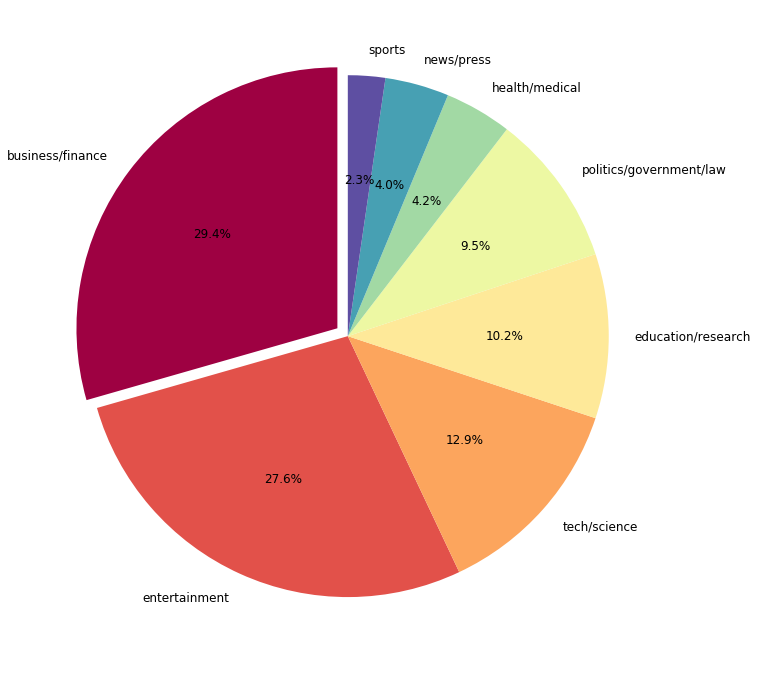

In [3]:
plt.figure(figsize=(12,12))
mpl.rcParams['font.size'] = 12.0
labels = train_df["label"].value_counts().index
sizes = train_df["label"].value_counts().values
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
explode = (0.05, 0, 0, 0, 0, 0, 0, 0)

plt.pie(sizes, labels=labels, explode=explode, colors=colors, autopct='%1.1f%%', startangle=90)
plt.show()

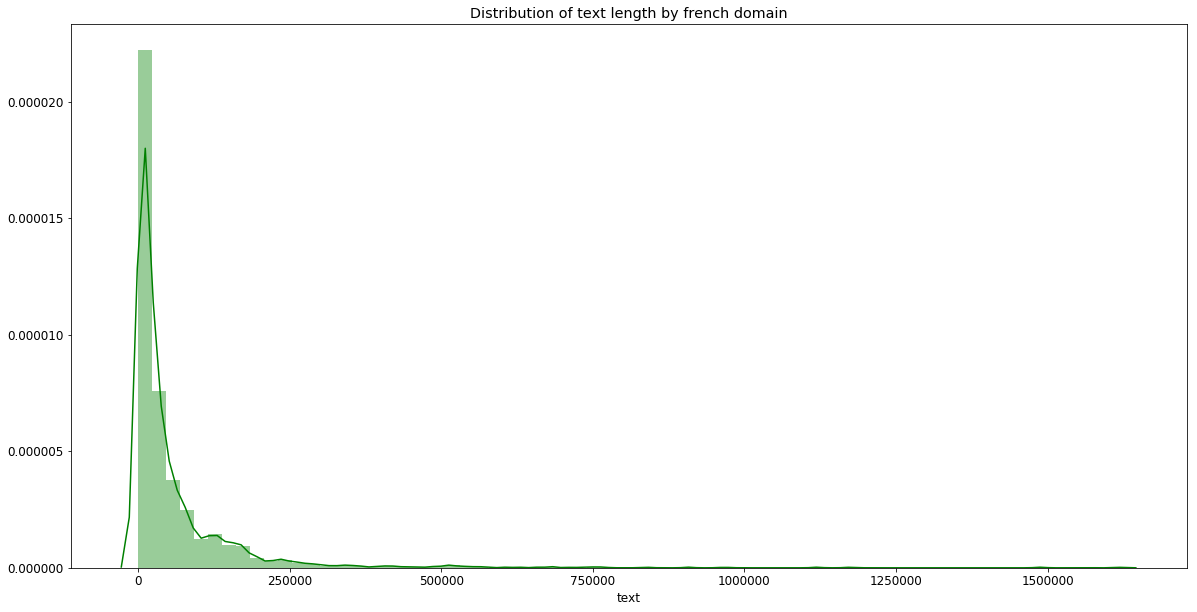

In [4]:
plt.figure(figsize=(20,10))
sns.distplot(train_df["text"].apply(lambda x: len(x)), bins = 70, color = "green")
plt.title("Distribution of text length by french domain")
plt.show()

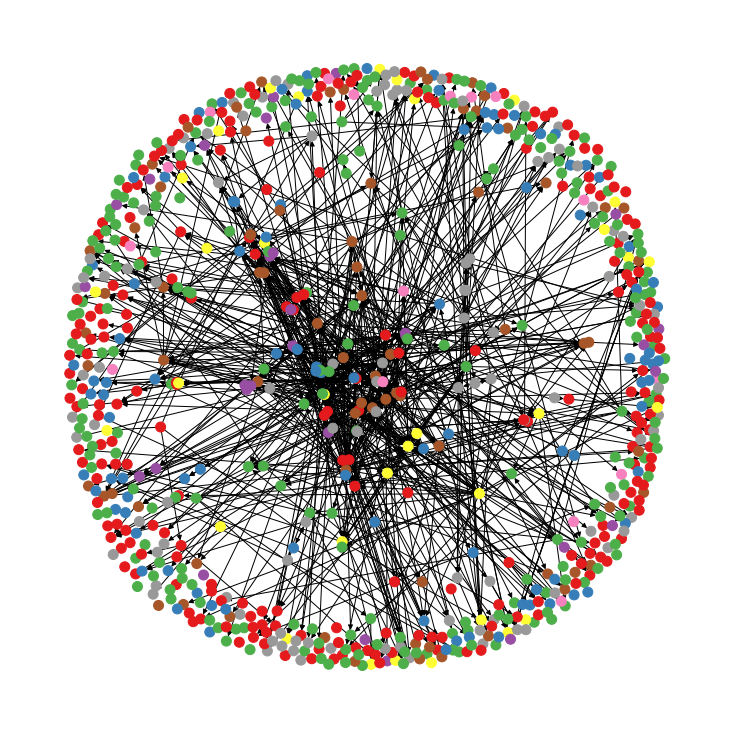

In [5]:
temp_df = train_df.sample(800).copy()
temp_df['index'] = temp_df['index'].astype(str)
node_list = temp_df['index'].to_list()
temp_df = temp_df.set_index('index')

mini_graph = graph.copy()
for node in tqdm_notebook(list(mini_graph.nodes)):
    if node not in node_list:
        mini_graph.remove_node(node)
        
temp_df = temp_df.reindex(mini_graph.nodes())
 
# And I need to transform my categorical column in a numerical value: group1->1, group2->2...
temp_df['label']=pd.Categorical(temp_df['label'])
 
# Custom the nodes:
plt.figure(figsize=(10,10)) 
nx.draw(mini_graph, with_labels=False, node_color=temp_df['label'].cat.codes, cmap=plt.cm.Set1, node_size=100)
plt.show()

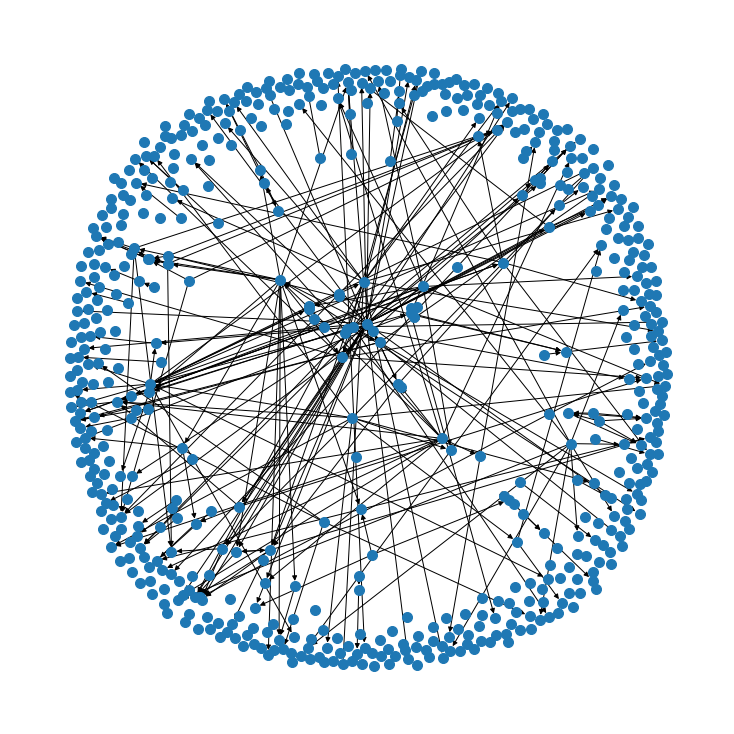

In [6]:
node_list = train_df[train_df["label"]=="business/finance"]['index'].astype(str).to_list()
mini_graph = graph.copy()
for node in tqdm_notebook(list(mini_graph.nodes)):
    if node not in node_list:
        mini_graph.remove_node(node)
        
plt.figure(figsize=(10,10)) 
nx.draw_spring(mini_graph, node_size=100)
plt.show()

# Scoring and Plotting Functions

In [7]:
def base_score(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)
    clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)
    return log_loss(y_test, y_pred)

In [8]:
def plot_2D(X_train):
    pca = PCA(n_components=2)
    features_df = pd.DataFrame(pca.fit_transform(np.array(X_train)))
    features_df["label"] = train_df["label"]
    features_df.columns = ["X","Y","label"]
    fig, ax = plt.subplots(figsize=(15,8), facecolor='white')
    for color in features_df['label'].unique():
        ax.scatter(features_df[features_df['label']==color]["X"], features_df[features_df['label']==color]["Y"], label=color,
                   alpha=0.9, edgecolors='none')
    ax.legend()
    ax.grid(True)
    plt.show()

# Clean text

In [9]:
def process_text(text):
    
    stopwords_fr = nltk.corpus.stopwords.words("french")
    stopwords_en = nltk.corpus.stopwords.words("english")
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    # while word tokenizing, replace ' by a space to further remove stopwords
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent.replace("'"," "))]
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = []
    for token in tokens:
        if not bool(re.compile(r'[^a-zÀ-ÿ-\']').search(token)):
            if re.search('[a-zÀ-ÿ]', token):
                filtered_tokens.append(token)
        
    #remove stopwords
    filtered_tokens = [token for token in filtered_tokens if token not in stopwords_fr+stopwords_en]
    
    # remove one letter words
    filtered_tokens = [token for token in filtered_tokens if len(token)>2]
    
    return " ".join(filtered_tokens)

for i in tqdm_notebook(np.arange(len(train_df))):
    train_df.loc[i, "clean_text"] = process_text(train_df.loc[i, "text"])

for i in tqdm_notebook(np.arange(len(test_df))):
    test_df.loc[i, "clean_text"] = process_text(test_df.loc[i, "text"])
    
# Remove lines with empty text
train_df["clean_text"] = train_df["clean_text"].fillna("")
# Fill Null text with empty string
test_df["clean_text"] = test_df["clean_text"].fillna("")

print(train_df.shape, test_df.shape)

# Save data
train_df.drop(columns=['text']).to_csv('cleantext_train.csv', index=False)
test_df.drop(columns=['text']).to_csv('cleantext_test.csv', index=False)


(1994, 5) (560, 3)


In [10]:
#train_df = pd.read_csv("cleantext_train.csv")
#test_df = pd.read_csv("cleantext_test.csv")

# TF-IDF features

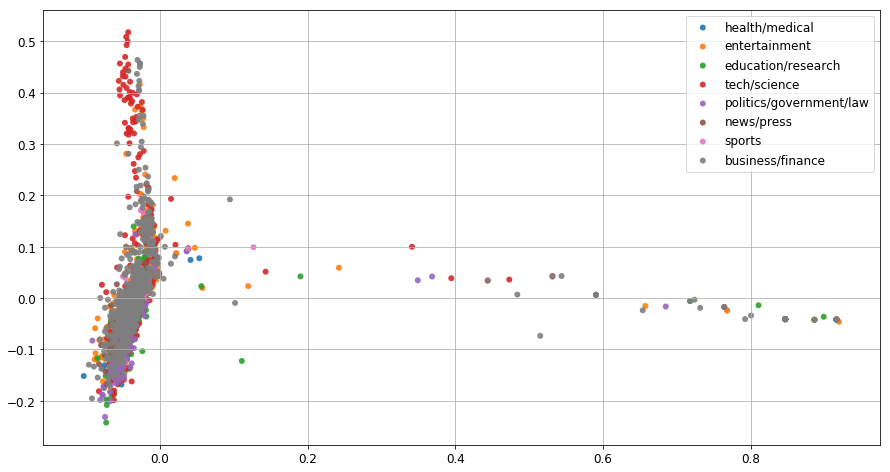

Base Model score:  1.3411511654848072


In [11]:
vec = TfidfVectorizer(min_df=10, max_df=1000)
X_train_tfidf = vec.fit_transform(train_df["clean_text"]).toarray()
X_test_tfidf = vec.transform(test_df["clean_text"]).toarray()

plot_2D(X_train_tfidf)
print("Base Model score: ", base_score(X_train_tfidf, train_df["label_encoded"]))

# Doc2Vec features

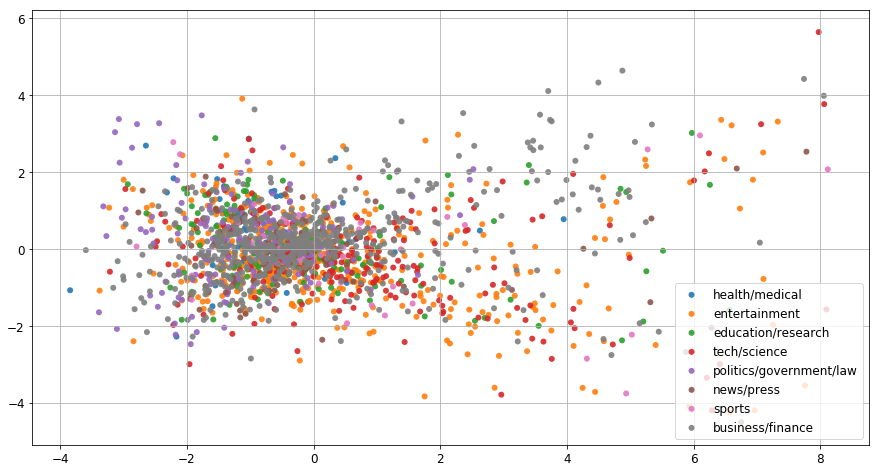

Base Model score:  1.657717665930593


In [12]:
corpus_train = [TaggedDocument(text,['d{}'.format(idx)]) for idx, text in enumerate(train_df['clean_text'])]
corpus_test = [TaggedDocument(text,['d{}'.format(idx)]) for idx, text in enumerate(test_df['clean_text'])]

model = Doc2Vec(corpus_train,vector_size=1000, min_count=0)
X_train_doc2vec = [model.docvecs[i] for i in range(len(train_df))]

model = Doc2Vec(corpus_test,vector_size=1000, min_count=0)
X_test_doc2vec = [model.docvecs[i] for i in range(len(test_df))]

plot_2D(X_train_doc2vec)
print("Base Model score: ", base_score(X_train_doc2vec, train_df["label_encoded"]))

# CamemBERT model

Important note: since we couldn't properly install transformers locally, we used Google Colab to do it. So run this code in Google Collab and import the proper data in order to execute it. 

In [13]:
'''
# Note: This code should be run on Google Colab
# You need to create a folder called ALTEGRAD and add the clean text files to it

!pip install transformers
%tensorflow_version 2.x
from google.colab import drive 
drive.mount("/content/drive")

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm_notebook

import os 
#path_to_folder = "/content/drive/My Drive/ALTEGRAD"
#os.chdir(path_to_folder)

from transformers import CamembertTokenizer, CamembertModel


tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertModel.from_pretrained('camembert-base')
model.to('cuda')

def CamemBERT_features_df(my_df):
    camembert_features=[]
    for index, row in tqdm_notebook(my_df.iterrows()):
        try :
            tokens = tokenizer.encode(row["clean_text"], add_special_tokens=True)
            shape = len(tokens[1:-1])
            new_tokens = []
            for i in range(int(shape/510)+1):
            min_shape = min((i+1)*510,shape)
            if min_shape == shape :
                L = [tokenizer.cls_token_id] + tokens[i*510:min_shape] + [tokenizer.eos_token_id]
                new_tokens.append(L + [tokenizer.pad_token_id]*(512 - len(L)))
            else :
                new_tokens.append([tokenizer.cls_token_id] + tokens[i*510:min_shape] + [tokenizer.eos_token_id] )
            with torch.no_grad() :
                camembert_features_temp = model(torch.tensor(new_tokens).cuda())[0][:,0,:]
            del new_tokens
            torch.cuda.empty_cache()
            if index == 0 :
                camembert_features = camembert_features_temp.detach().cpu().numpy().mean(axis=0).reshape(1,-1)
            else :
                camembert_features = np.concatenate((camembert_features, 
                                        camembert_features_temp.detach().cpu().numpy().mean(axis=0).reshape(1,-1)), 
                                      axis=0)
        except :
            camembert_features = np.concatenate((camembert_features, np.zeros((1,768))), axis=0)
    
    new_df = pd.DataFrame(np.array(camembert_features))
    new_df['index'] = my_df["index"]
    return new_df

train_camembert_df = CamemBERT_features_df(train_df)
test_camembert_df = CamemBERT_features_df(test_df)

train_camembert_df['label_encoded'] = train_df["label_encoded"]

train_camembert_df.to_csv('train_camembert.csv', index=False)
test_camembert_df.to_csv('test_camembert.csv', index=False)
'''

'\n# Note: This code should be run on Google Colab\n# You need to create a folder called ALTEGRAD\n\n!pip install transformers\n%tensorflow_version 2.x\nfrom google.colab import drive \ndrive.mount("/content/drive")\n\nimport pandas as pd\nimport numpy as np\nimport torch\nfrom tqdm import tqdm_notebook\n\nimport os \n#path_to_folder = "/content/drive/My Drive/ALTEGRAD"\n#os.chdir(path_to_folder)\n\nfrom transformers import CamembertTokenizer, CamembertModel\n\n\ntokenizer = CamembertTokenizer.from_pretrained(\'camembert-base\')\nmodel = CamembertModel.from_pretrained(\'camembert-base\')\nmodel.to(\'cuda\')\n\ndef CamemBERT_features_df(my_df):\n    camembert_features=[]\n    for index, row in tqdm_notebook(my_df.iterrows()):\n        try :\n            tokens = tokenizer.encode(row["clean_text"], add_special_tokens=True)\n            shape = len(tokens[1:-1])\n            new_tokens = []\n            for i in range(int(shape/510)+1):\n            min_shape = min((i+1)*510,shape)\n     

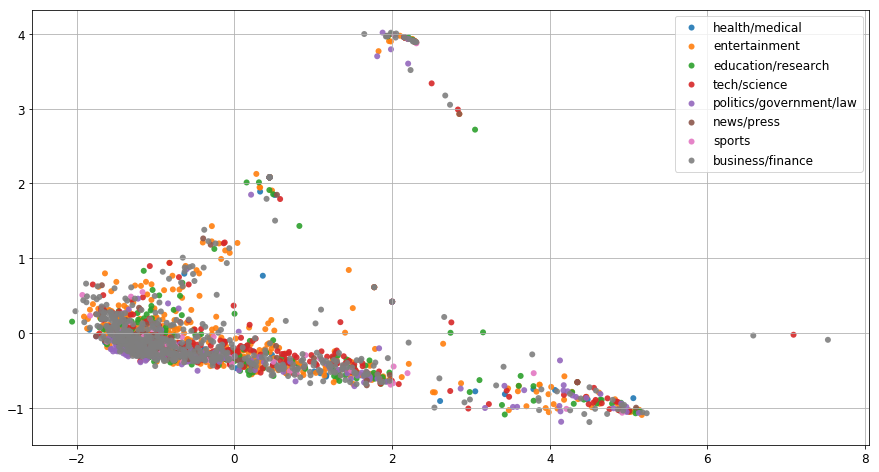

Base Model score:  1.2365958253177267


In [14]:
X_train_camembert = pd.read_csv('train_camembert.csv').drop(['label_encoded','index'],axis=1)
X_test_camembert = pd.read_csv('test_camembert.csv')

plot_2D(X_train_camembert)
print("Base Model score: ", base_score(X_train_camembert, train_df["label_encoded"]))

# Simple Graph Features

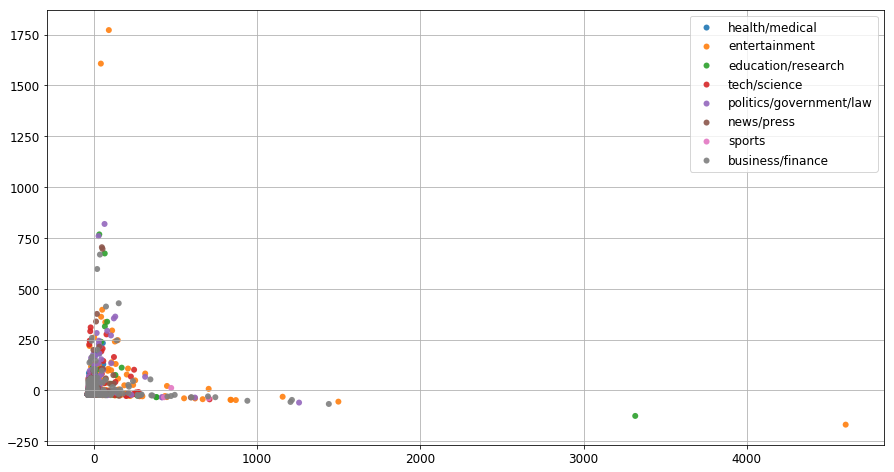

Base Model score:  1.7505664167686972


In [15]:
# Create the training matrix. Each row corresponds to a web host.
# Use the following 3 features for each web host (unweighted degrees)
# (1) out-degree of node
# (2) in-degree of node
# (3) average degree of neighborhood of node
X_train_graph = np.zeros((len(train_df), 3))
X_test_graph = np.zeros((len(test_df), 3))

avg_neig_deg = nx.average_neighbor_degree(graph, nodes=train_df["index"].astype("str").values)
for index, row in tqdm_notebook(train_df.iterrows()):
    X_train_graph[index,0] = graph.in_degree(str(row["index"]))
    X_train_graph[index,1] = graph.out_degree(str(row["index"]))
    X_train_graph[index,2] = avg_neig_deg[str(row["index"])]

avg_neig_deg = nx.average_neighbor_degree(graph, nodes=test_df["index"].astype("str").values)
for index, row in tqdm_notebook(test_df.iterrows()):
    X_test_graph[index,0] = graph.in_degree(str(row["index"]))
    X_test_graph[index,1] = graph.out_degree(str(row["index"]))
    X_test_graph[index,2] = avg_neig_deg[str(row["index"])]

plot_2D(X_train_graph)    
print("Base Model score: ", base_score(X_train_graph, train_df["label_encoded"]))

# Node2Vec Features

Generating walks (CPU: 1): 100%|██████████| 100/100 [04:45<00:00,  3.58s/it]


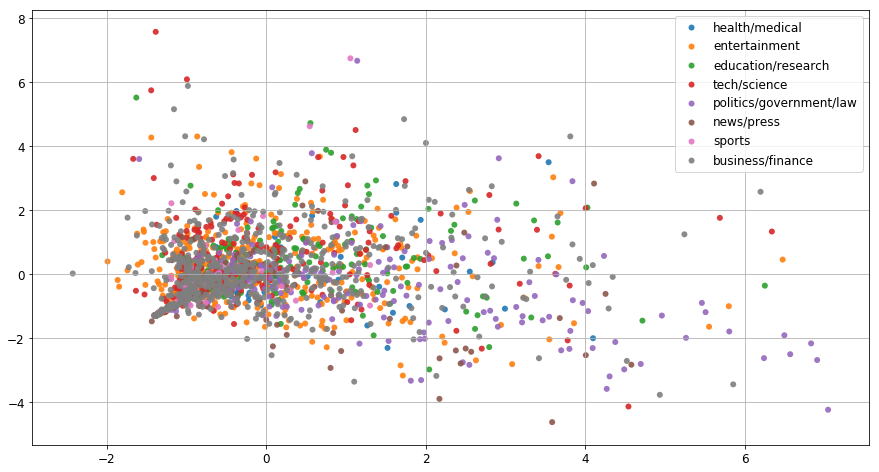

Base Model score:  1.626165420638883


In [16]:
# Generate walks
node2vec = Node2Vec(graph, dimensions=64, walk_length=15, num_walks=100)
# Learn embeddings
model = node2vec.fit(window=6, min_count=1)
# Generate features
X_train_node2vec = [model.wv.get_vector(str(i)) for i in train_df["index"].values] 
X_test_node2vec = [model.wv.get_vector(str(i)) for i in test_df["index"].values] 

plot_2D(X_train_node2vec)
print("Base Model score: ", base_score(X_train_node2vec, train_df["label_encoded"]))

# DeepWalk Features

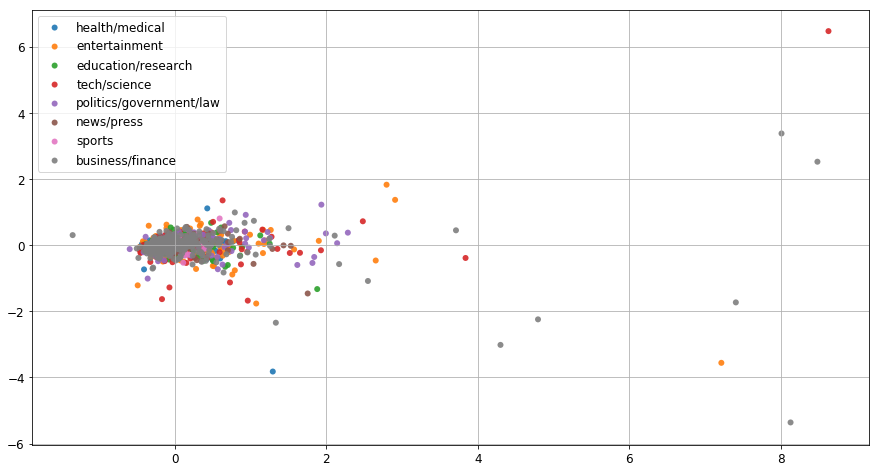

Base Model score:  1.7640857471615619


In [17]:
model = DeepWalk(walk_number=3, walk_length=60, dimensions=64, workers=4, window_size=5)

graph.add_node("17591")
model.fit(graph)

X_train_deepwalk = model.get_embedding()[train_df["index"].values]
X_test_deepwalk = model.get_embedding()[test_df["index"].values]

plot_2D(X_train_deepwalk)
print("Base Model score: ", base_score(X_train_deepwalk, train_df["label_encoded"]))

# Tuning Hyper Parameters

In [19]:
def cv_score(model, X):
    return -round(np.mean(cross_validate(model, X, train_df["label_encoded"], 
                                  scoring = 'neg_log_loss', cv=5)['test_score']),3)

lr_model = LogisticRegression(multi_class='auto', max_iter=500, penalty='l2')
rf_model = RandomForestClassifier(max_depth=8, random_state=0, n_estimators=100, min_samples_split=2, min_samples_leaf=1)
xg_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=11, missing=-999, n_estimators=100,
             n_jobs=1, nthread=4, objective='multi:softprob', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337,
             subsample=0.8, verbosity=1)


print("LogisticRegression:\n")
print("TF-IDF score: ", cv_score(lr_model, X_train_tfidf))
print("Doc2Vec score: ", cv_score(lr_model, np.array(X_train_doc2vec)))
print("CamemBERT score: ", cv_score(lr_model, X_train_camembert))
print("Graph features score: ", cv_score(lr_model, X_train_graph))
print("Node2Vec score: ", cv_score(lr_model, X_train_node2vec))
print("DeepWalk score: ", cv_score(lr_model, X_train_deepwalk))

print("\n\nRandomForestClassifier:\n")
print("TF-IDF score: ", cv_score(rf_model, X_train_tfidf))
print("Doc2Vec score: ", cv_score(rf_model, np.array(X_train_doc2vec)))
print("CamemBERT score: ", cv_score(rf_model, X_train_camembert))
print("Graph features score: ", cv_score(rf_model, X_train_graph))
print("Node2Vec score: ", cv_score(rf_model, X_train_node2vec))
print("DeepWalk score: ", cv_score(rf_model, X_train_deepwalk))

print("\n\nXGBoostClassifier:\n")
print("TF-IDF score: ", cv_score(xg_model, X_train_tfidf))
print("Doc2Vec score: ", cv_score(xg_model, np.array(X_train_doc2vec)))
print("CamemBERT score: ", cv_score(xg_model, X_train_camembert))
print("Graph features score: ", cv_score(xg_model, X_train_graph))
print("Node2Vec score: ", cv_score(xg_model, np.array(X_train_node2vec)))
print("DeepWalk score: ", cv_score(xg_model, X_train_deepwalk))

LogisticRegression:

TF-IDF score:  1.329
Doc2Vec score:  1.797
CamemBERT score:  1.296
Graph features score:  1.77
Node2Vec score:  1.744
DeepWalk score:  1.797


RandomForestClassifier:

TF-IDF score:  1.547
Doc2Vec score:  1.598
CamemBERT score:  1.515
Graph features score:  1.766
Node2Vec score:  1.541
DeepWalk score:  1.778


XGBoostClassifier:

TF-IDF score:  1.314
Doc2Vec score:  1.531
CamemBERT score:  1.356
Graph features score:  1.775
Node2Vec score:  1.489
DeepWalk score:  1.8


# Final Model (used for submission)

In [20]:
from sklearn.ensemble import VotingClassifier
lr_model = LogisticRegression(multi_class='auto', max_iter=500, penalty='l1')
rf_model = RandomForestClassifier(max_depth=8, random_state=0, n_estimators=100, min_samples_split=2, min_samples_leaf=1)

pca = PCA(n_components=1500)
pca.fit(X_train_tfidf)
X_train_tfidf_pca = pca.transform(X_train_tfidf)
X_test_tfidf_pca = pca.transform(X_test_tfidf)

X_train_final = np.concatenate((X_train_tfidf_pca, X_train_camembert,X_train_node2vec),axis=1)
X_test_final = np.concatenate((X_test_tfidf_pca, X_test_camembert,X_test_node2vec),axis=1)
y_final = train_df["label"]

lr_model = LogisticRegression(multi_class='auto', max_iter=500, penalty='l1')
xg_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=11, missing=-999, n_estimators=100,
             n_jobs=1, nthread=4, objective='multi:softprob', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337,
             subsample=0.8, verbosity=1)

ensemble = VotingClassifier(estimators=[('Logistic Regression', lr_model), ('XGboost', xg_model)], voting='soft')
ensemble.fit(X_train_final, y_final)

y_pred = ensemble.predict_proba(X_test_final)

In [21]:
# Write predictions to a file
with open('final_submission.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = ensemble.classes_.tolist()
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i,test_host in enumerate(test_df["index"]):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)